In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl

from ex_cosmology import p
from dset import get_dataloader, load_pretrained_model
from dset import get_validation

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform2d import DWT2d
from utils import get_2dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_2dfilts, plot_2dreconstruct, plot_wavefun

# evaluation
from eval_cosmology import load_results, rmse_bootstrap, extract_patches
from peak_counting import PeakCount, rmse
from matplotlib import gridspec
import random

# TRIM module
sys.path.append('../../lib/trim')
from trim import TrimModel
from utils import tuple_to_tensor, tensor_to_tuple

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load results

In [3]:
dirs = [
        "db5_saliency_warmstart_seed=1_new"
        ]
dics, _, _ = load_results(dirs)

In [4]:
# get dataloader and model
train_loader, val_loader = get_dataloader(p.data_path, 
                                          img_size=p.img_size[2],
                                          split_train_test=True,
                                          batch_size=p.batch_size) 

model = load_pretrained_model(model_name='resnet18', device=device, data_path=p.model_path)   

# validation dataset
test_loader = get_validation(p.data_path, 
                             img_size=p.img_size[2],
                             batch_size=p.batch_size)

In [6]:
# load optimal wavelet for prediction on heldout dataset
scores = pkl.load(open('results/scores_new.pkl', 'rb'))
row, col = np.unravel_index(np.argmin(scores, axis=None), scores.shape)
bds = np.linspace(0.015,0.035,5)
bd_opt = bds[row]
idx1, idx2 = list(dics[0]['wt'].keys())[col-1]
wt = dics[0]['wt'][(idx1, idx2)]   
lamL1wave = dics[0]['lamL1wave'][(idx1, idx2)]
lamL1attr = dics[0]['lamL1attr'][(idx1, idx2)]
print('lambda: {} gamma: {}'.format(lamL1wave, lamL1attr))

lambda: 0.02 gamma: 0.00368


# plot histograms

In [8]:
# wavelet
filt = get_2dfilts(wt)
h = filt[0][0]
g = filt[0][1]
kernels = extract_patches(h, g)
pcw = PeakCount(peak_counting_method='custom', 
                bins=np.linspace(0,bd_opt,23),
                kernels=kernels)
pcw.fit(train_loader)

# laplace filter
pcl = PeakCount(peak_counting_method='laplace_v1',
                bins=np.linspace(0,0.22,23))
pcl.fit(train_loader)

# roberts cross
pcr = PeakCount(peak_counting_method='roberts_cross',
                bins=np.linspace(0,0.22,23))
pcr.fit(train_loader)

# peak height
pco = PeakCount(peak_counting_method='original',
                bins=np.linspace(-0.03,0.19,23))
pco.fit(train_loader)

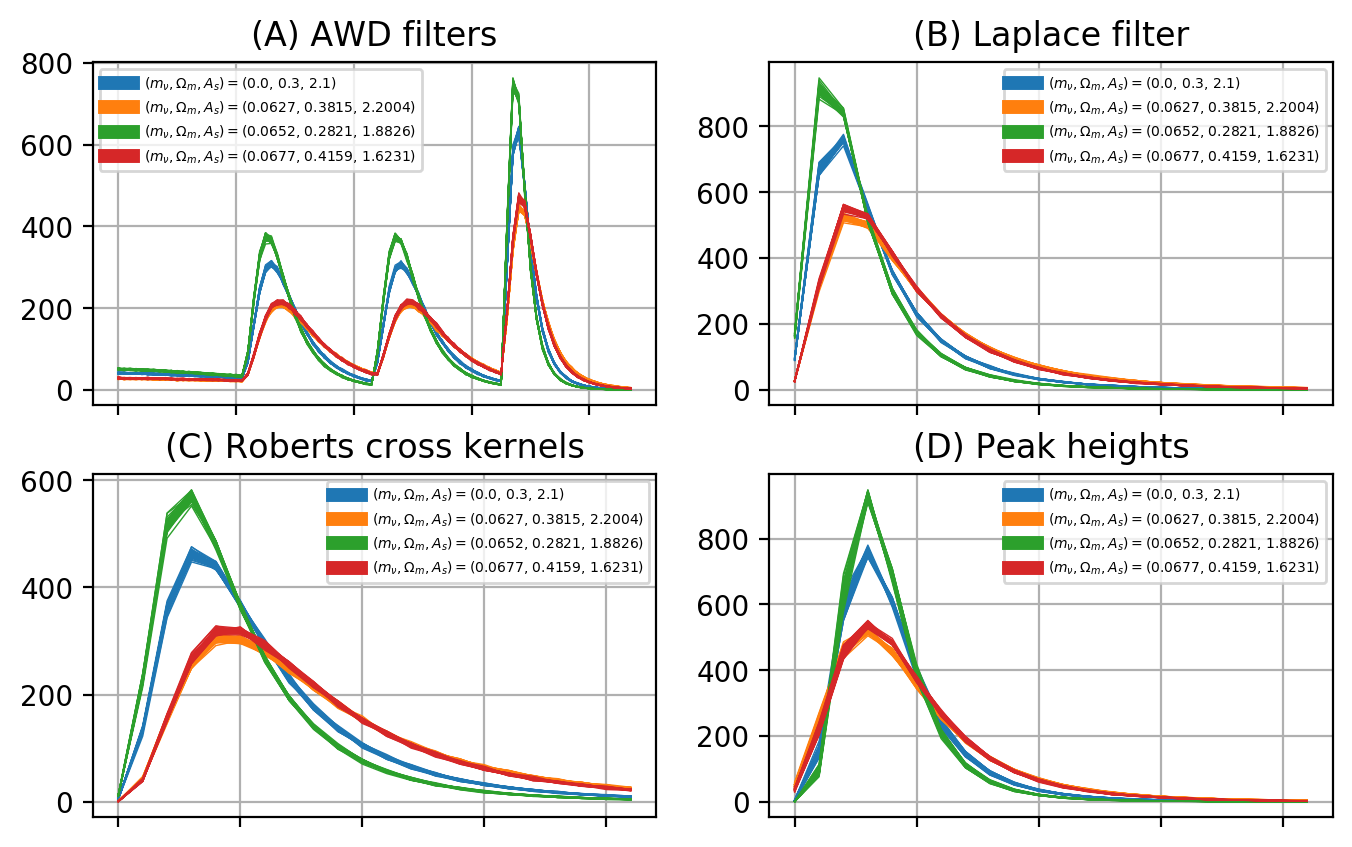

In [18]:
fig = plt.figure(figsize=(8,5), dpi=200)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
colors = ['C0', 'C1', 'C2', 'C3']

# histograms for wavelet
ax_00 = fig.add_subplot(spec[0, 0])
i = 0
for k in sorted(pcw.peak_list.keys()):
    param = (np.round(k[0], 4), np.round(k[1], 4), np.round(k[2], 4))
    if i <= 3:
        # empty plot for labels
        ax_00.plot([], lw=5, label=r'$(m_\nu,\Omega_m,A_s)=$'+str(param))
        for j in range(50):
            # plots
            hp = np.vstack(random.sample(pcw.peak_list[k], 30))
            ax_00.plot(np.mean(hp, axis=0), '-', lw=0.5, color=colors[i])
        i += 1
ax_00.legend(fontsize=5, loc='upper left', fancybox=True)      
ax_00.set_xticklabels([])
ax_00.grid()
ax_00.set_title("(A) AWD filters")

# histograms for laplace 
ax_01 = fig.add_subplot(spec[0, 1])
i = 0
for k in sorted(pcl.peak_list.keys()):
    param = (np.round(k[0], 4), np.round(k[1], 4), np.round(k[2], 4))
    if i <= 3:
        # empty plot for labels
        ax_01.plot([], lw=5, label=r'$(m_\nu,\Omega_m,A_s)=$'+str(param))
        for j in range(50):
            # plots
            hp = np.vstack(random.sample(pcl.peak_list[k], 30))
            ax_01.plot(np.mean(hp, axis=0), '-', lw=0.5, color=colors[i])
        i += 1
ax_01.legend(fontsize=5, loc='upper right', fancybox=True)    
ax_01.set_xticklabels([])
ax_01.grid()
ax_01.set_title("(B) Laplace filter")

# histograms for roberts cross 
ax_10 = fig.add_subplot(spec[1, 0])
i = 0
for k in sorted(pcr.peak_list.keys()):
    param = (np.round(k[0], 4), np.round(k[1], 4), np.round(k[2], 4))
    if i <= 3:
        # empty plot for labels
        ax_10.plot([], lw=5, label=r'$(m_\nu,\Omega_m,A_s)=$'+str(param))
        for j in range(50):
            # plots
            hp = np.vstack(random.sample(pcr.peak_list[k], 30))
            ax_10.plot(np.mean(hp, axis=0), '-', lw=0.5, color=colors[i])
        i += 1
ax_10.legend(fontsize=5, loc='upper right', fancybox=True)    
ax_10.set_xticklabels([])
ax_10.grid()
ax_10.set_title("(C) Roberts cross kernels")

# histograms for peak height
ax_11 = fig.add_subplot(spec[1, 1])
i = 0
for k in sorted(pco.peak_list.keys()):
    param = (np.round(k[0], 4), np.round(k[1], 4), np.round(k[2], 4))
    if i <= 3:
        # empty plot for labels
        ax_11.plot([], lw=5, label=r'$(m_\nu,\Omega_m,A_s)=$'+str(param))
        for j in range(50):
            # plots
            hp = np.vstack(random.sample(pco.peak_list[k], 30))
            ax_11.plot(np.mean(hp, axis=0), '-', lw=0.5, color=colors[i])
        i += 1
ax_11.legend(fontsize=5, loc='upper right', fancybox=True)      
ax_11.set_xticklabels([])
ax_11.grid()
ax_11.set_title("(D) Peak heights")

fig.savefig(
    "figures/cosmo_histograms_density.pdf", bbox_inches="tight", pad_inches=0.0
)

[]

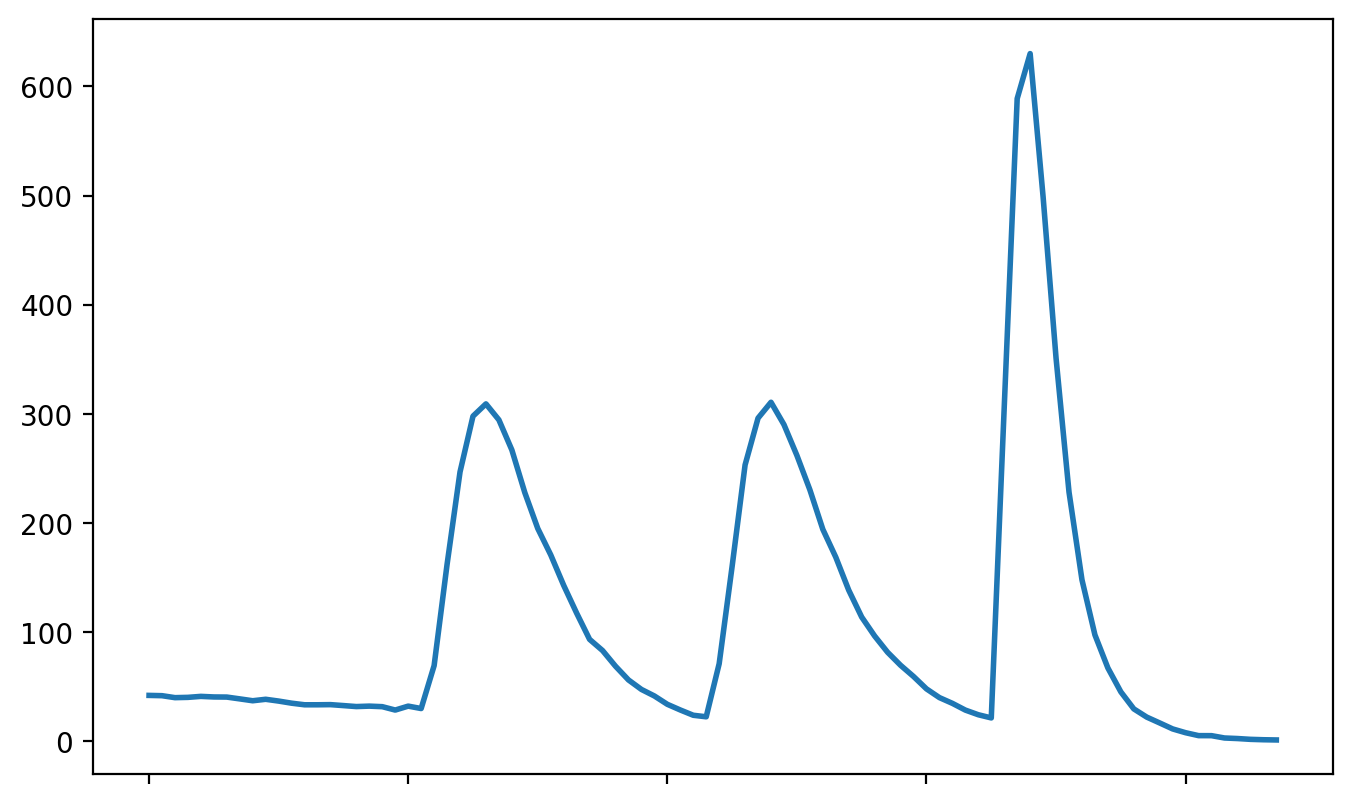

In [10]:
fig = plt.figure(figsize=(8,5), dpi=200)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
colors = ['C0', 'C1', 'C2', 'C3']

# histograms for wavelet
ax_00 = fig.add_subplot(spec[0, 0])
i = 0
for k in sorted(pcw.peak_list.keys()):
    param = (np.round(k[0], 4), np.round(k[1], 4), np.round(k[2], 4))
    if i <= 0:
        # empty plot for labels
        ax_00.plot([], lw=5, label=r'$(m_\nu,\Omega_m,A_s)=$'+str(param))
        for j in range(1):
            # plots
            hp = np.vstack(random.sample(pcw.peak_list[k], 30))
            ax_00.plot(np.mean(hp, axis=0), '-', lw=2, color=colors[i])
        i += 1   
ax_00.set_xticklabels([])

